## Summarize the nb

### Load

In [105]:
import os
import jax
import sys
import jax.numpy as jnp
import optax
from typing import NamedTuple
from ilqr_vae_jax import dynamics, vae, prior, encoder, likelihood, typs, coupler, defaults
from ilqr_vae_jax.typs import *
import numpy as np
import h5py
import pickle
from matplotlib import pyplot as plt


## Define parameters

In [106]:
n = 32
m = 2 
true_n = 2
batch_size = 32
num_train_trials = 128
n_out = 10
true_c = jax.random.normal(jax.random.PRNGKey(0), shape = (n_out, true_n))
dt = 0.05
true_a = np.asarray([[1-0.2*dt,-2*dt], [2*dt, 1-0.2*dt]])
true_a_eig, _ = np.linalg.eig(true_a)
T = 100
n_encoder = 128
m_encoder = 128
m_controller = 128
dir_name = "tmp_results"
os.makedirs(dir_name, exist_ok=True)

## Generate the data

In [107]:
def generate_traj(key):
    key, subkey = jax.random.split(key)
    subkey, subsubkey = jax.random.split(subkey)
    x0 = 0.05*jax.random.normal(key,shape= (true_n,))
    us = jnp.concatenate([jnp.zeros(40), jnp.ones(1), jnp.zeros(T - 41)])[...,None]
    u_idx = jax.random.normal(key = subsubkey, shape = (1,true_n))
    us = us*u_idx
    us = jnp.array(us)
    def dynamics(x, u):
        nx = true_a@x + u*dt
        return nx, nx
    x0, xs = jax.lax.scan(dynamics, x0, us)
    y = (xs@true_c.T) 
    noise = 0.001*jax.random.normal(key, shape = (T,n_out))
    y += noise
    return (y, us)

def sample_train_data(key, batch_size):
    keys = jax.random.split(key, batch_size)
    y, us = jax.vmap(generate_traj)(keys)
    std_y = jnp.std(y.reshape(-1, y.shape[-1]), axis = 0)
    mean_y = jnp.mean(y.reshape(-1, y.shape[-1]), axis = 0)
    y = (y - mean_y)/std_y
    return jnp.concatenate([jnp.arange(T)[None,...] for _ in range(batch_size)], axis = 0), us, y 


train_data = sample_train_data(jax.random.PRNGKey(122), batch_size = num_train_trials)
train_data = (train_data[0], train_data[1], (train_data[-1] - np.mean(train_data[-1].reshape(-1, train_data[-1].shape[-1])))/np.std(train_data[-1].reshape(-1, train_data[-1].shape[-1])))


class Dataloader():
    def __init__(self, data, batch_size):
        self.Ts = data[0]
        self.ext_us = data[1]
        self.ys = data[2]
        self.total_samples = len(self.ys)
        self.batch_size = batch_size
        self.key = jax.random.PRNGKey(0)
        
    def save_test_data(self, saving_dir):
        pass 
    
    def sample_test_data(self):
        key = jax.random.PRNGKey(0)
        _, us, os = sample_train_data(key, batch_size = 64)
        return jnp.concatenate([jnp.arange(T)[None,...] for _ in range(64)], axis = 0), us, os
    def __len__(self):
            return (self.total_samples + self.batch_size - 1) // self.batch_size
    def __iter__(self):
        key, subkey = jax.random.split(self.key)
        self.key = subkey
        idces = jax.random.permutation(self.key, jnp.arange(self.total_samples))
        self.ys = self.ys[idces]
        self.ext_us = self.ext_us[idces]
        for i in range(len(self)):
            start = i * self.batch_size
            end = min(start + self.batch_size, self.total_samples)
            y, ext_us = self.ys[start:end], self.ext_us[start:end]
            yield self.Ts[start:end], ext_us, y, jnp.arange(start, end)
            
train_dataloader = Dataloader(train_data, batch_size)

### Plot the data

Text(0, 0.5, 'Observation')

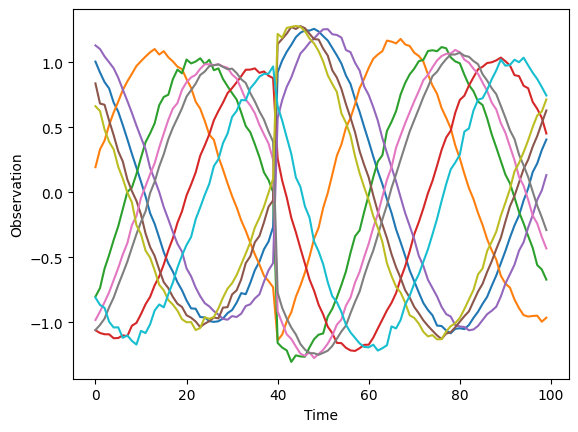

In [108]:
ys = train_data[-1]
plt.plot(ys[0])
plt.xlabel('Time')
plt.ylabel('Observation')

## Fit the model

In [110]:
prior_choice = 'student' #gaussian or student

optimizer = optax.adam
dims = typs.Dims(n_out = n_out, n = n, m = m, m_encoder = m_encoder, n_encoder = n_encoder, m_controller = m_controller, n_controller = 64, horizon = T)
dyn_module = dynamics.VRNN(phi = lambda x : x, dims = dims)
prior_module = prior.Student(dims = dims) if prior_choice == 'student' else prior.Gaussian(dims = dims)
likelihood_module = likelihood.Gaussian(dims = dims)
encoder_module = encoder.BiRNN(dims = dims)
coupler_module = coupler.GRUController(dims =dims)
lr_scheduler = optax.exponential_decay(0.01, transition_steps = 1, decay_rate = 0.999)
training_hparams = defaults.default_training_hparams
training_hparams = training_hparams._replace(total_num_datapoints = num_train_trials, num_epochs = 100, batch_size = batch_size, lr_scheduler = lr_scheduler, optimizer = optimizer)
vae_module = vae.VAE(dynamics = dyn_module, prior = prior_module, likelihood = likelihood_module, coupler = coupler_module, encoder = encoder_module, dataloader = train_dataloader, training_hparams = training_hparams, dims = dims, inputs_allowed=1, saving_dir = dir_name)

##need to separate out dimensions of pb and hyperparams
vae_module.train()

epoch 0 | time = 20.04688310623169| loss: 1.4286755895926624 ~ ll: -14278.776064668367. entropy: 215.88759247826601. log_prior: -3264.4336031136068
epoch 1 | time = 24.279726028442383| loss: 1.1328695314937864 ~ ll: -10774.188330994502. entropy: -152.51579821181096. log_prior: -4097.592495553895
epoch 2 | time = 26.517176866531372| loss: 1.1313051409968569 ~ ll: -10414.606106468822. entropy: -124.66273322625673. log_prior: -3351.6870142884704
epoch 3 | time = 29.054436922073364| loss: 1.14724972274887 ~ ll: -10234.660297430954. entropy: 193.48372321968046. log_prior: -3396.262182230047
epoch 4 | time = 31.275134086608887| loss: 1.1251060642418127 ~ ll: -9706.61517192208. entropy: 344.5379242933675. log_prior: -3346.3987974101537
epoch 5 | time = 33.42264413833618| loss: 1.1174656191181338 ~ ll: -9337.27445753337. entropy: 382.79556988182014. log_prior: -3242.6025672015935
epoch 6 | time = 35.80573105812073| loss: 1.120790314477782 ~ ll: -9118.874620610986. entropy: 543.0601916273523. l

In [117]:
## Plot the loss

In [ ]:
loss = vae_module.losses
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')

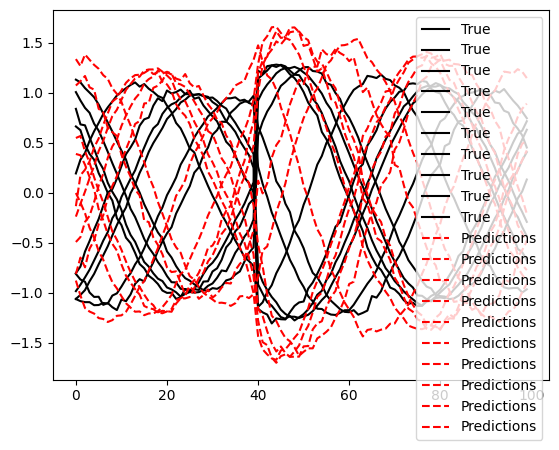

In [114]:
## plot the predictions
predictions = np.load(f"{dir_name}/predictions.npy")

plt.plot(ys[0], "k", label = "True")
plt.plot(predictions[0], "--r", label = "Predictions")
plt.legend()



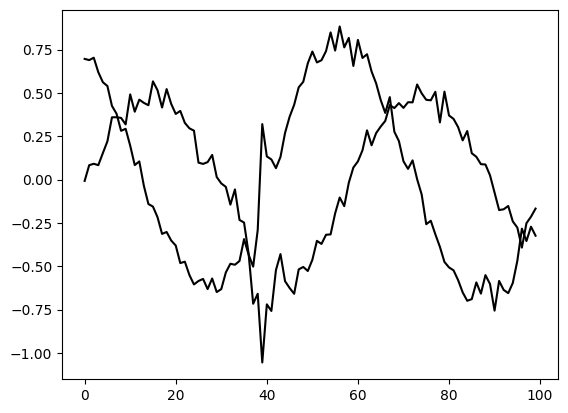

In [115]:
## plot the inputs
us = np.load(f"{dir_name}/inputs.npy")
plt.plot(us[0], "k", label = "True")

Text(0, 0.5, 'Imaginary')

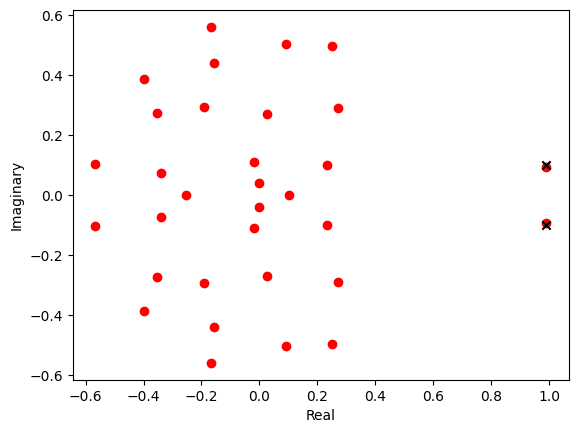

In [116]:

##plot the true / learned eigenvalues
true_a_eig = np.linalg.eig(true_a)[0]
learned_a_eig = np.linalg.eig(vae_module.params.dyn_params.a)[0]
plt.figure()
plt.scatter(learned_a_eig.real, learned_a_eig.imag, color = "r", label = "Learned")
plt.scatter(true_a_eig.real, true_a_eig.imag, color = "k", marker = "x", label = "True")
plt.xlabel("Real")
plt.ylabel("Imaginary")